# Assessing Stability of K-Means: A Follow Up

Some years ago I posted an article on Assessing the Stability of K-means (http://activisiongamescience.github.io/2016/08/19/Assessing-Stability-of-K-Means-Clusterings/) and while my methods haven't changed too much since that time I have made enough incremental advancements that I felt it was worth sharing where I am now and how I've fully automated my process to deliver results in hours. First, I recommend you read the first article as this is more of a supplementary to that article rather than a standalone piece. Secondly, even though this article is titled 'K-means' I believe this stability methodology is generally extensible to any unsupervised methods that needs to fit stability criterion. Another area to research in the future.

That said let's jump right into it. We're going to use the same dataset we used in the previous article, the 2013 American Community Survey (https://www.kaggle.com/census/2013-american-community-survey) and we'll be focusing on the wealth distribution of Americans. We'll be producing a segmentation based on variables like work house per week, income sources, age groups and levels of education. Instead of interpretability, this time we will focus on how to efficiently determine stability and explore some other tricks that I've learned in the intervening years to speed up the discovery process.

In [104]:
setwd("C:/Users/drogerson/Work_Directory")


#install.packages("flexclust",repos="http://cran.stat.ucla.edu/")

#Turn Off Warnings
options(warn=-1)

# For Heatmaps.2
library(gplots)
# Plotting Library
library(ggplot2)
# Library to Color our Heatmaps
library(RColorBrewer)
#For scoring K-means on a new Dataset
library(flexclust)
#Packages to do parallel computing
library(foreach)
library(doParallel)

#Turn On Warnings
options(warn=0)

# Creating a palette for Heatmaps
mypalette <- brewer.pal(10,"RdBu")

# Our Survey Data - Please read this file from the downloaded data from the American Community Survey
datacs <- read.csv("./GAS Presentation/ss13pusa.csv")

After loading our data we'll again do some simple transforms, focusing on adults of at least 21 years of age and people who earned money.

In [105]:
set.seed(5) #Make sure to set a seed for reproducibility

datprep1 <- datacs[datacs$AGEP>=21,c("WAGP","WKHP","SCHL","OIP","INTP","AGEP","pwgtp1","pwgtp2")]

datprep1[is.na(datprep1)] <- 0

# Only include people who made money from wages or interest/dividends
datprep1a <- (datprep1[datprep1$WAGP > 0 & datprep1$INTP >= 0,])

print("Total Number of Rows in Our Dataset")
nrow(datprep1a)
print("First 6 Rows in Our Dataset")
head(datprep1a)
print("Summary of Our Dataset")
summary(datprep1a)

[1] "Total Number of Rows in Our Dataset"


[1] 707659

[1] "First 6 Rows in Our Dataset"


,WAGP,WKHP,SCHL,OIP,INTP,AGEP,pwgtp1,pwgtp2
2,52000,40,20,0,0,55,45,51
6,39000,40,21,0,0,63,481,575
12,90000,48,16,0,0,59,83,58
13,46000,40,18,0,0,56,69,49
17,20000,25,21,0,0,72,60,163
18,28000,40,19,0,0,52,29,91


[1] "Summary of Our Dataset"


      WAGP             WKHP            SCHL           OIP         
 Min.   :     4   Min.   : 1.00   Min.   : 1.0   Min.   :    0.0  
 1st Qu.: 16000   1st Qu.:36.00   1st Qu.:16.0   1st Qu.:    0.0  
 Median : 34000   Median :40.00   Median :19.0   Median :    0.0  
 Mean   : 47441   Mean   :39.03   Mean   :18.6   Mean   :  404.2  
 3rd Qu.: 60000   3rd Qu.:43.00   3rd Qu.:21.0   3rd Qu.:    0.0  
 Max.   :660000   Max.   :99.00   Max.   :24.0   Max.   :83000.0  
      INTP             AGEP           pwgtp1           pwgtp2      
 Min.   :     0   Min.   :21.00   Min.   : -28.0   Min.   :  -8.0  
 1st Qu.:     0   1st Qu.:32.00   1st Qu.:  36.0   1st Qu.:  36.0  
 Median :     0   Median :44.00   Median :  75.0   Median :  75.0  
 Mean   :  1465   Mean   :44.22   Mean   : 103.3   Mean   : 103.4  
 3rd Qu.:     0   3rd Qu.:55.00   3rd Qu.: 131.0   3rd Qu.: 131.0  
 Max.   :300000   Max.   :95.00   Max.   :2494.0   Max.   :2420.0  

We'll also scale our variables and run them through PCA removing the final component as it contributes less than 7% to the total variance in our data.

In [106]:
#Prep the Full Dataset

datprep2<-datprep1a[,1:6]
datprep4 <- apply(datprep2,2,scale)

#Curb Outliers
datprep4[datprep4>2]<-2
datprep4[datprep4<(-2)]<-(-2)

#Perform PCA

pcadat<-prcomp(datprep4,
               center = TRUE,
               scale. = TRUE)

print("Summary of the PCA Components of Our Dataset")
summary(pcadat)

#Cut off the last loading
datprep5<-pcadat$x
datprep6<-datprep5[,1:(ncol(datprep5)-1)]

randomSample<-runif(nrow(datprep1a))

holdout<-datprep6[randomSample>=0.9,] #Holdout for Cluster Label Comparision (Rand Index)
train<-datprep6[randomSample<0.9,] #Data to Train the Clustering Models on

trainRaw<-datprep2[randomSample<0.9,]

[1] "Summary of the PCA Components of Our Dataset"


Importance of components:
                          PC1    PC2    PC3    PC4    PC5     PC6
Standard deviation     1.3162 1.0554 0.9965 0.9682 0.8981 0.64545
Proportion of Variance 0.2887 0.1856 0.1655 0.1562 0.1344 0.06943
Cumulative Proportion  0.2887 0.4744 0.6399 0.7961 0.9306 1.00000

In [107]:
summary(train)

      PC1                 PC2                 PC3           
 Min.   :-6.563249   Min.   :-8.036859   Min.   :-6.020021  
 1st Qu.:-0.738451   1st Qu.:-0.481260   1st Qu.:-0.021839  
 Median : 0.130120   Median : 0.152146   Median : 0.159744  
 Mean   : 0.000387   Mean   : 0.000192   Mean   :-0.000026  
 3rd Qu.: 0.910712   3rd Qu.: 0.721434   3rd Qu.: 0.354579  
 Max.   : 3.579223   Max.   : 2.382108   Max.   : 2.057768  
      PC4                 PC5           
 Min.   :-4.277149   Min.   :-7.560387  
 1st Qu.:-0.650655   1st Qu.:-0.430831  
 Median : 0.000658   Median : 0.054758  
 Mean   : 0.000945   Mean   :-0.000403  
 3rd Qu.: 0.651324   3rd Qu.: 0.542359  
 Max.   : 5.269863   Max.   : 2.833168  

### The Segmentation Loop

Now that we have a fully prepped dataset we can move on to the major focus for this article: The SegmentationLoop. From our previous articles it's clear that K-means segmentation does not always converge to a global minimum. As such, we expect to repeat a segmentation several times in order to find out what's stable. Our goal is to run the loop below hundreds of times in parallel and store the results for analysis later.

A quick summary of the loop below:

1) Work off an initial dataset which is a subsample of the total dataset (by default 100k observations)

2) Use a cluster initialization as described in Dasgupta and Schulman (2007)

3) If that produces a number of initial centers < k (rare but can happen) then simply initialize from the first few unique rows in the training data

4) Perform a Kmeans segmentation saving the centers (both in PCA and 'real' space for interpretability)

5) Record the centers (both for train and raw data), the run and the model.

6) Finally we score the first 1000 rows of the holdout dataset. This will allow us compare clusters with a similarity score.

In [108]:
SegmentationLoop <- function(ksize, train, trainRaw, holdout, sampsize = 100000, run = 1) {
  
  #iclustering <- 2
  #Last updated 3-12-19
  
  #1) Work off of an initial dataset which is a subsample of the total dataset (by default 100k observations)  
    
  samplingIntegers<-sample(1:nrow(train),sampsize)
  datprepOriginal<-train[samplingIntegers,]
  datprepRaw<-trainRaw[samplingIntegers,]
  
  #2) Initialization Method For Kmeans Described in Dasgupta and Schulman (2007)
  
  initialKmeans <- kmeans(datprepOriginal, ceiling(ksize*log(ksize)),iter.max = 1)
  validCenters <- initialKmeans$size/nrow(datprepOriginal)*ceiling(ksize*log(ksize)) > 1/2
  centersNoOutliers <- initialKmeans$centers[validCenters,]
  
  
  if (sum(validCenters) > ksize) {
    
    nextCenter <- centersNoOutliers[1,] #Start with a Random Center
    initialCenters <- data.frame(t(nextCenter))
    centersConsidered <- 2:nrow(centersNoOutliers) #Keep track of the centers that can still be added
    
    for(i in 1:(ksize-1)){
      
      k2 <- matrix(,ncol = nrow(centersNoOutliers),nrow = i)
      
      for(k in 1:i) {
        
        for( j in 1:nrow(centersNoOutliers)) {
          k2[k,j] <- sum((centersNoOutliers[j,]-initialCenters[k,])^2)
        }
      } #Create a Distance Matrix between the centers currently selected and all centers
      
      if(i == 1){
        k3 <- k2}else{
          clusterWithMaxMinDistance <- which.max(apply(k2[,centersConsidered],1,FUN=min))
          k3 <- k2[clusterWithMaxMinDistance,]
        } #Calculating relevant distances to find the cluster that maximizes the minimum distance to the centers already selected.
      
      nextCenter <- centersNoOutliers[centersConsidered[which.max( k3[centersConsidered])],] 
      #Select the center which maximizes the minimum distance to one of the centers already selected
      centersConsidered <- centersConsidered[-which.max( k3[centersConsidered])]
      #One selected we have to remove it from the centers that are still up for selection
      initialCenters <- rbind(initialCenters,nextCenter)
      #And finally add the new center to the list of initialization centers for K-means.
      
    }
    
  } else if ( sum(validCenters) == ksize) {initialCenters <- centersNoOutliers #3) If Exactly Equal
  } else { initialCenters <- unique(head(datprepOriginal,100))[1:ksize,] } #3) If all else fails use unique random points from the first 1000 rows
  
  
  
  #4) Perform a Kmeans segmentation saving the centers (both in PCA and 'real' space for interpretability)
  
    PCAKmeans <- kcca(datprepOriginal, k = as.matrix(initialCenters), kccaFamily("kmeans"),simple=TRUE)
  
    clustersize <- PCAKmeans@clusinfo$size/sum(PCAKmeans@clusinfo$size)
    testcluster <- aggregate(datprepOriginal,by=list(PCAKmeans@cluster),FUN = mean)
    testcluster <- testcluster[,2:ncol(testcluster)]
    testClusterRealValues <- aggregate(datprepRaw,by=list(PCAKmeans@cluster),FUN = mean)
  
  #5) Finally we record the centers (both for train and raw data) and the run.
    new <- testcluster
    new$segment <- 1:ksize
    new$run <- run
    
    rawCenters <- testClusterRealValues
    rawCenters$segment <- 1:ksize
    rawCenters$run <- run
    rawCenters$size <- clustersize
    
   #6) Labeling the holdout dataset with the model and using it to calculate the Rand Index  
    labelsTest <- predict(PCAKmeans,holdout)
    
    list(new,rawCenters[,2:ncol(rawCenters)],labelsTest,PCAKmeans)
    
  
}

In [109]:
loopOutput <- SegmentationLoop( 4, train, trainRaw, holdout[1:1000,])

Warning message:
"did not converge in 1 iteration"

So here we see the output of one iteration of the loop:

1) The centers of the train data (the model in PCA space)

2) The centers of the trainRaw data (the model in real space)

3) The model scores on the holdout set, used for comparison between segmentations

4) The model that was created

In [110]:
loopOutput

[[1]]
         PC1         PC2         PC3         PC4        PC5 segment run
1 -1.6063387  0.05776251  0.06171961  0.04146547  0.1293728       1   1
2  0.6489389 -1.19752651 -4.68717291 -0.36475919 -0.2269234       2   1
3  0.5742457 -0.64159426  0.41541132 -0.62024649  0.2460607       3   1
4  0.6831777  0.67402278  0.06115262  0.59693629 -0.2965463       4   1

[[2]]
       WAGP     WKHP     SCHL         OIP       INTP     AGEP segment run
1 100126.20 47.15874 20.86487    16.23868 4194.83754 48.58626       1   1
2  31785.64 37.72306 18.59136 10377.51171 1084.53071 45.43207       2   1
3  27409.89 35.02910 16.60232    30.00611  557.15925 55.13186       3   1
4  25505.81 36.22193 18.68907    31.46286   57.69947 30.44354       4   1
     size
1 0.28247
2 0.03842
3 0.32710
4 0.35201

[[3]]
   [1] 1 3 4 3 4 4 1 1 3 3 3 3 1 3 3 1 3 4 3 3 1 4 3 4 3 3 4 3 1 4 3 4 4 3 4 4 4
  [38] 3 4 4 3 3 3 3 2 1 4 4 4 4 3 4 4 1 4 4 3 1 4 3 1 1 4 2 1 3 3 4 4 1 2 4 3 1
  [75] 3 1 4 3 1 4 4 3 1 4 1 4 4 3 4 3

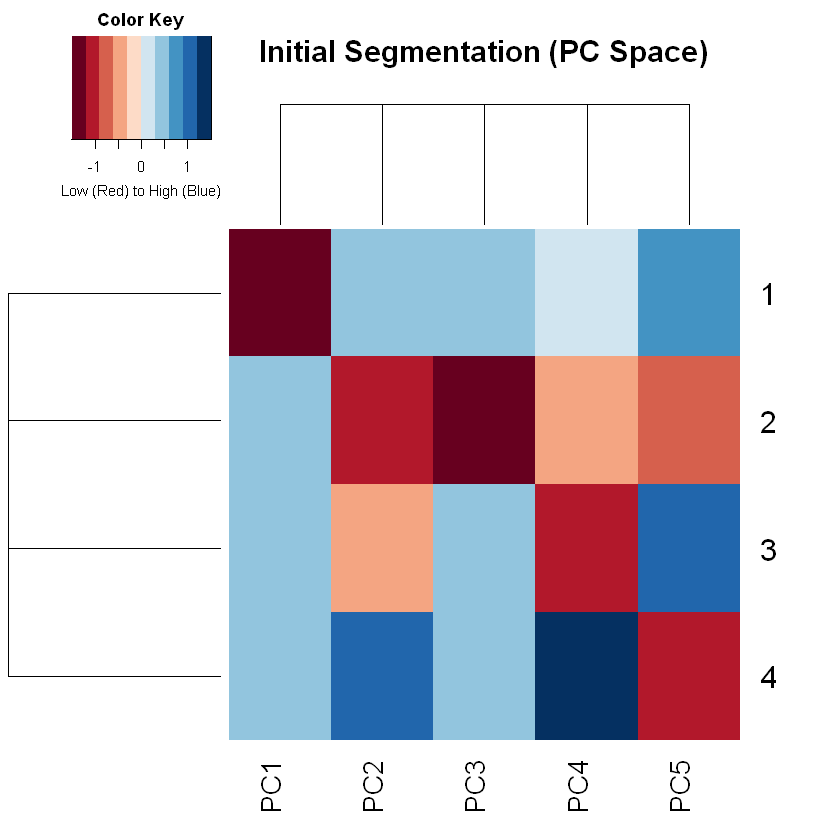

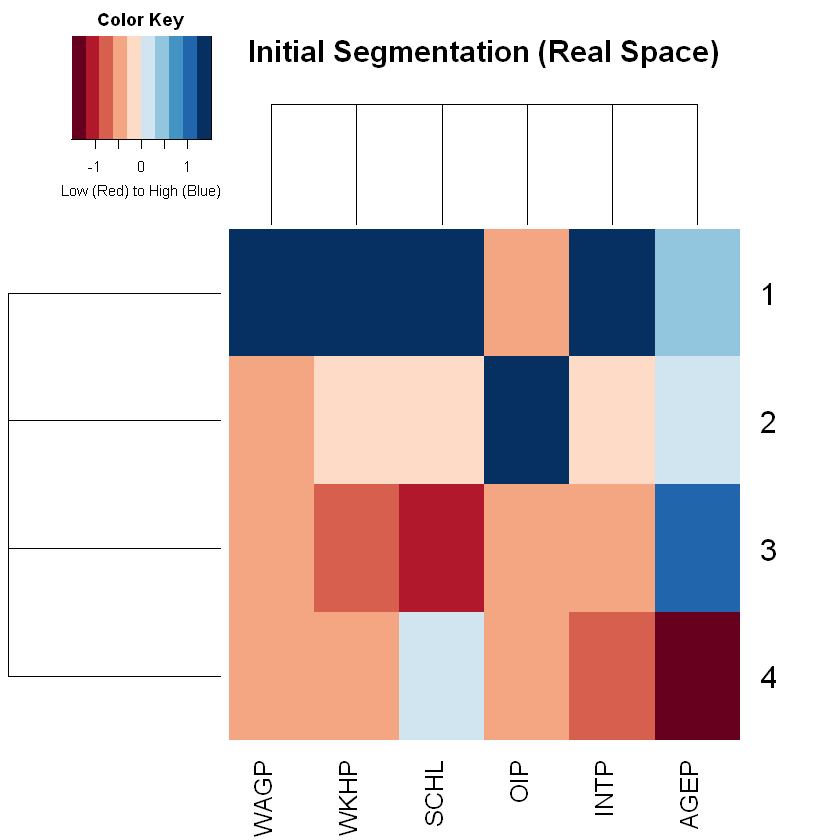

In [111]:
firstPlot <- as.matrix(as.data.frame(loopOutput[[1]])[1:5])
secondPlot <- as.matrix(as.data.frame(loopOutput[[2]])[1:6])

heatmap.2(firstPlot,scale = "column",notecol = "black",Rowv = "False",Colv = "False"
                 ,main = "Initial Segmentation (PC Space)",col = mypalette,key.xlab = "Low (Red) to High (Blue)", trace = "none",density.info = "none")

heatmap.2(secondPlot,scale = "column",notecol = "black",Rowv = "False",Colv = "False"
                 ,main = "Initial Segmentation (Real Space)",col = mypalette,key.xlab = "Low (Red) to High (Blue)", trace = "none",density.info = "none")


### Running 100 Segmentations and Comparing Them

So now let's record 100 runs and compare our clusters. The loop is written to be entirely parallelizable. Each of the output types above will be stored in separate tables.

In [112]:
bootstraps <- 100 #Run 100 times

ptm <- proc.time() 

cl <- makeCluster(6) #Use 6 cores
registerDoParallel(cl) # Start Parallel

finalOutput <- foreach( iclustering = 1:bootstraps, .combine = c, .export = c('kcca','kccaFamily','predict') ) %dopar%
  SegmentationLoop( 4, train, trainRaw, holdout[1:1000,], run = iclustering)

stopCluster(cl)

print(paste("Clustering Complete: ",round(proc.time() - ptm )[3]," seconds"))


[1] "Clustering Complete:  61  seconds"


Now finalOutput contains a list of 100 outputs of the SegmentationLoop. So let's stich these together into the data we're interested in:

output) The centers of the train data (the model in PCA space)

outputRaw) The centers of the trainRaw data (the model in real space)

labelResults) The model scores on the holdout set, used for comparison between segmentations

modelResults) The model that was created

In [113]:
output <- do.call('rbind',(finalOutput[(1:bootstraps*4 - 3)]))
outputRaw <- do.call('rbind',(finalOutput[(1:bootstraps*4 - 2)]))
labelResults <- do.call('rbind',(finalOutput[(1:bootstraps*4 - 1)]))
modelResults <- finalOutput[(1:bootstraps*4)]

Now comes the interesting part. Let's create a distance matrix between each segmentation we've produced. Our 'distance' metric will be randIndex (Adjusted Rand Index), as referenced in the previous article (also here https://en.wikipedia.org/wiki/Rand_index). Once interesting tidbit I missed during my earlier work is that randIndex (from the flexclust package) already permutes through labels to find the best rand index removing the need to reorder the segment labels! While this may seem minor, this actually means that we don't have to worry about an initial segmentation and we know longer have to worry about biasing our results but what segmentation we randomly started with.

In [114]:
randIndex(c(1,1,2,2,3,4,3,4,5),c(2,2,1,1,4,3,4,3,5))

ARI 
  1

Computing this distance matrix can also be computationally intense and scales as number of segmentations squared. For this reason I've decided to parallelize this code as well.

In [115]:
ptm <- proc.time() 

cl <- makeCluster(6) #Use 6 cores
registerDoParallel(cl) # Start Parallel

gridDef <- expand.grid(1:bootstraps,1:bootstraps)

randMatOutput <- foreach( irand = 1:(bootstraps^2), .combine = c, .export = c('randIndex') ) %dopar%
  {randIndex(labelResults[gridDef$Var1[irand],],labelResults[gridDef$Var2[irand],])}

stopCluster(cl)

print(paste("Rand Indexing Complete: ",(proc.time() - ptm )[3]," seconds"))

randMat <- matrix(randMatOutput, nrow = bootstraps)

[1] "Rand Indexing Complete:  8.4399999999996  seconds"


Below you'll see our distance matrix and of course all of our diagonal elements are 1 and it's reflected about the diagonal since 

\begin{align}
 rand(x,y) & = rand(y,x) \\
 rand(x,x) & = 1 \\
\end{align}

In [116]:
head(randMat)

1.0000000,0.9938893,0.5619612,0.5477811,0.9906758,0.9939470,0.9911267,0.9938893,0.9906170,0.9906170,...,0.9971711,0.9911899,0.9906758,0.9939449,0.9906170,0.9818296,0.9967142,0.9911145,0.9883695,0.9906727
0.9938893,1.0000000,0.5624438,0.5482895,0.9911179,0.9943989,0.9906722,1.0000000,0.9967177,0.9967177,...,0.9967176,0.9850893,0.9911179,0.9943970,0.9967177,0.9879214,0.9971666,0.9972257,0.9888295,0.9911149
0.5619612,0.5624438,1.0000000,0.9821637,0.5642514,0.5665446,0.5615879,0.5624438,0.5601592,0.5601592,...,0.5598284,0.5656863,0.5663279,0.5669086,0.5622271,0.5694900,0.5645816,0.5647670,0.5706569,0.5695369
0.5477811,0.5482895,0.9821637,1.0000000,0.5500738,0.5523368,0.5474654,0.5482895,0.5460351,0.5460351,...,0.5457037,0.5515104,0.5521206,0.5526663,0.5480733,0.5552418,0.5503720,0.5505801,0.5563957,0.5552651
0.9906758,0.9911179,0.5642514,0.5500738,1.0000000,0.9967108,0.9873397,0.9911179,0.9943991,0.9943991,...,0.9878457,0.9873951,0.9934310,0.9912013,0.9878463,0.9790970,0.9939518,0.9883617,0.9911242,0.9879298
0.9939470,0.9943989,0.5665446,0.5523368,0.9967108,1.0000000,0.9906108,0.9943989,0.9911179,0.9911179,...,0.9911175,0.9906650,0.9967108,0.9944729,0.9911179,0.9823416,0.9972323,0.9916339,0.9944121,0.9911920


Now in particular we're interested in the segmentation which gave the highest on average randIndex to all other segmentations, the 'bestRandIndex'.

In [117]:
randMatAverages <- (colSums(randMat)-1)/(bootstraps-1)
bestRandIndex <- max((colSums(randMat)-1)/(bootstraps-1)) #Mean Rand Index to all OTHER clusters..ignoring the perfect 1.0 match to your own
print('Our Best Average Rand Index')
bestRandIndex
output[output$run == which.max(randMatAverages),] #Most Consistent Cluster

[1] "Our Best Average Rand Index"


[1] 0.9350043

,PC1,PC2,PC3,PC4,PC5,segment,run
141,0.6731719,0.6740064,0.05896585,0.59107895,-0.2979266,1,36
142,-1.6083408,0.0611783,0.06130435,0.03466128,0.1295126,2,36
143,0.6582604,-1.1641874,-4.67900791,-0.35501324,-0.2415868,3,36
144,0.5785312,-0.6433193,0.41342246,-0.60984570,0.2466979,4,36


In [118]:
as.data.frame(outputRaw[outputRaw$run == which.max(randMatAverages),])

,WAGP,WKHP,SCHL,OIP,INTP,AGEP,segment,run,size
141,25660.93,36.32985,18.70279,33.14192,70.86722,30.50898,1,36,0.35577
142,100102.51,47.27152,20.86084,15.98853,4088.97939,48.61936,2,36,0.27895
143,32422.05,37.63651,18.56930,10310.48640,1209.96260,44.90220,3,36,0.03824
144,27171.69,34.94606,16.62280,31.63436,601.99783,55.06751,4,36,0.32704


Our best run was 87. Let's visualize those results, which look identical to our last article.

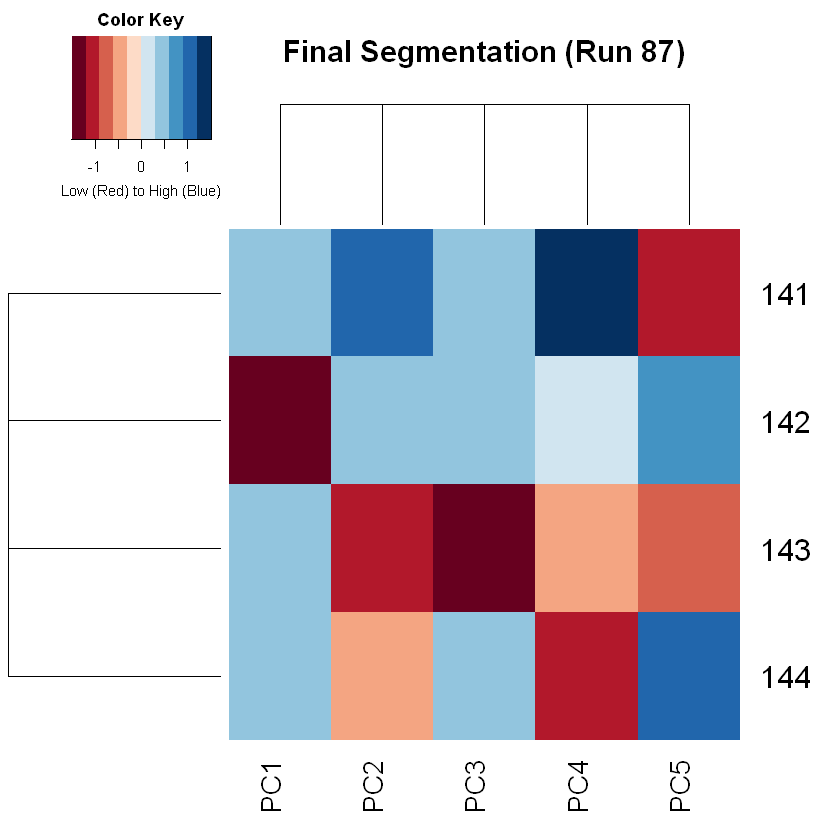

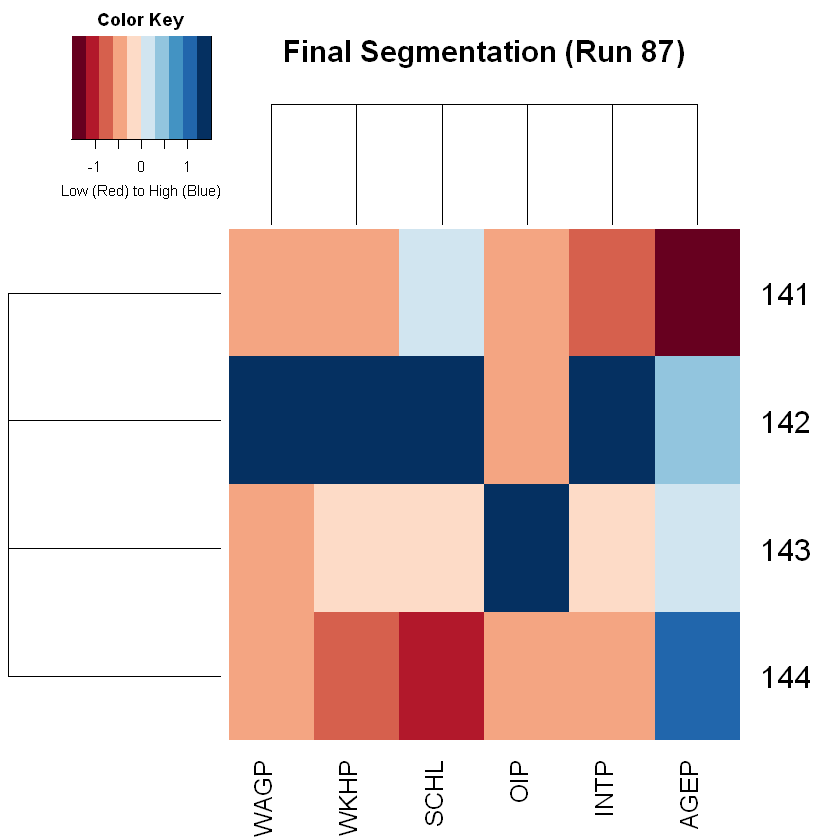

In [119]:
outputPlot <- as.matrix(as.data.frame(output[output$run == which.max(randMatAverages),])[,1:5])
outputPlotRaw <- as.matrix(as.data.frame(outputRaw[outputRaw$run == which.max(randMatAverages),])[,1:6])

heatmap.2(outputPlot,scale = "column",notecol = "black",Rowv = "False",Colv = "False"
                 ,main = "Final Segmentation (Run 36)",col = mypalette,key.xlab = "Low (Red) to High (Blue)", trace = "none",density.info = "none")

heatmap.2(outputPlotRaw,scale = "column",notecol = "black",Rowv = "False",Colv = "False"
                 ,main = "Final Segmentation (Run 36)",col = mypalette,key.xlab = "Low (Red) to High (Blue)", trace = "none",density.info = "none")


So what have we learned from doing 100 runs of this segmentation? Well first we know that the above segmentation has the best on average randIndex to all other runs and that the best average segmentation we can expect from k = 4 will only agree with other segmentations about 81% of the time (calculation below). A better way of looking at this is to keep in mind the best average randIndex is 0.94.

In [120]:
mean(randMat[36,]> .95)

[1] 0.81

### Picking K

So how to do we pick k? If we only care about the model being stable (which we do) then our metric of choice is this average randIndex. Now we simply have to set up a loop and go through each k we want to consider.

In [121]:
#Turn Off Warnings
options(warn=-1)


finalTable <- c()
models <- list()

for (ksize in 4:10) {
    
    bootstraps <- 100 #Produce 100 segmentations

    ptm <- proc.time() 

    cl <- makeCluster(6) #Use 6 cores
    registerDoParallel(cl) # Start Parallel

    finalOutput <- foreach( iclustering = 1:bootstraps, .combine = c, .export = c('kcca','kccaFamily','predict') ) %dopar%
      SegmentationLoop( ksize, train, trainRaw, holdout[1:1000,], run = iclustering)

    stopCluster(cl)

    print(paste("Clustering Complete: ",round(proc.time() - ptm )[3]," seconds"))
    
    #Combine the outputs
    
    output <- do.call('rbind',(finalOutput[(1:bootstraps*4 - 3)]))
    outputRaw <- do.call('rbind',(finalOutput[(1:bootstraps*4 - 2)]))
    labelResults <- do.call('rbind',(finalOutput[(1:bootstraps*4 - 1)]))
    modelResults <- finalOutput[(1:bootstraps*4)]
    
    #Calculating the rand distance matrix
    
    gridDef <- expand.grid(1:bootstraps,1:bootstraps)
    
    ptm <- proc.time() 

    cl <- makeCluster(6) #Use 6 cores
    registerDoParallel(cl) # Start Parallel

    randMatOutput <- foreach( irand = 1:(bootstraps^2), .combine = c, .export = c('randIndex') ) %dopar%
      {randIndex(labelResults[gridDef$Var1[irand],],labelResults[gridDef$Var2[irand],])}

    stopCluster(cl)

    randMat <- matrix(randMatOutput, nrow = bootstraps)

    print(paste("Rand Indexing Complete: ",(proc.time() - ptm )[3]," seconds"))
    
    #Picking the best segmentation
    
    randMatAverages <- (colSums(randMat)-1)/(bootstraps-1)
    bestRandIndex <- max((colSums(randMat)-1)/(bootstraps-1)) #Mean Rand Index to all OTHER clusters..ignoring the perfect 1.0 match to your own
    output[output$run == which.max(randMatAverages),] #Most Consistent Cluster
    
    
    finalTableEntry <- outputRaw[outputRaw$run == which.max(randMatAverages),] #Most Consistent Cluster
    finalTableEntry$rand <- bestRandIndex
    finalTableEntry$ksize <- ksize
    
    finalTable <- rbind(finalTable,finalTableEntry)
    models[length(models) + 1] <- modelResults[which.max(randMatAverages)][[1]]
    
    print("Optimal Cluster Determined")
    print(finalTableEntry)
}

#Turn On Warnings
options(warn=0)

[1] "Clustering Complete:  61  seconds"
[1] "Rand Indexing Complete:  8.46000000000004  seconds"
[1] "Optimal Cluster Determined"
        WAGP     WKHP     SCHL        OIP       INTP     AGEP segment run
85  32533.14 37.65234 18.58286 9861.28683 1056.88402 45.25574       1  22
86 100867.33 47.32437 20.87530   16.10355 4190.61324 48.70672       2  22
87  25609.53 36.35942 18.65858   33.24220   88.83844 30.59339       3  22
88  27436.34 35.07576 16.62115   31.00547  544.58281 55.19253       4  22
      size      rand ksize
85 0.03699 0.9245743     4
86 0.27891 0.9245743     4
87 0.35516 0.9245743     4
88 0.32894 0.9245743     4
[1] "Clustering Complete:  74  seconds"
[1] "Rand Indexing Complete:  9.14999999999964  seconds"
[1] "Optimal Cluster Determined"
         WAGP     WKHP     SCHL        OIP        INTP     AGEP segment run
136  31362.95 37.91407 18.50124 9904.57174   358.19168 44.67750       1  28
137 110956.53 39.84156 20.54442  279.01777 57379.91115 55.70089       2  28
138  26

### Conclusions

Let's finally plot the highest average adjusted rand index (ARI) over k. As you'll see stability doesn't always become better as we increase k. Some values of k are quite unstable and we really shouldn't consider them for analysis. In the graph below it's clear that k = 4 and k = 9 are quite stable (just like we found a few years ago).

In practice I'm interested in segmentations that have an average ARI of > 0.9 and I should mention that running only 100 runs (or bootstraps) is a little low. When calculating the average ARI multiple times I've seen some fluctuations of around ~5% . For instance the first time we ran an evalutation of k = 4 we saw an average ARI of 0.935 in line 117 and in the line above we see 0.924. It's probably good practice to pick a larger number of runs ( >250 ) if you want a lower error in your ARI calculation.

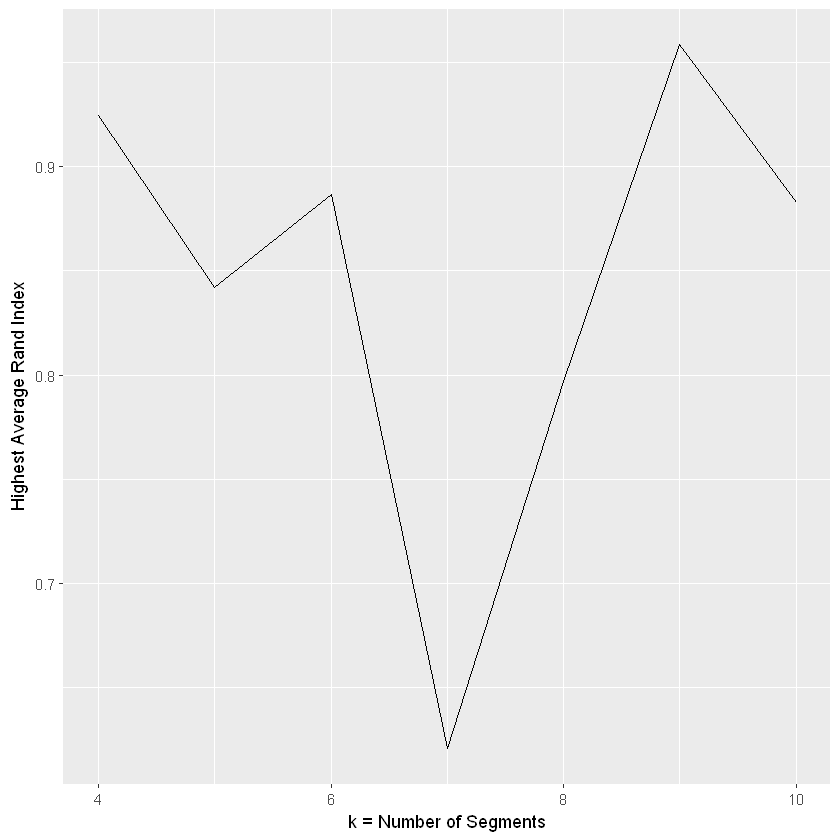

In [122]:
ggplot(finalTable, aes(x = ksize, y = rand)) + geom_line() + labs(x = 'k = Number of Segments', y = 'Highest Average Rand Index')

It's also worth showing the final output of our method, a list of the centers of every winning/highest ARI segmentation for every k considered. This table was used to make the above graph.

Thanks again for reading my article and I hope that I've at least demonstrated why I believe stability (along with a balance on interpretibility and stability) is necessary in order to pick the 'right' k.

In [123]:
finalTable

,WAGP,WKHP,SCHL,OIP,INTP,AGEP,segment,run,size,rand,ksize
85,32533.139,37.65234,18.58286,9861.28683,1056.88402,45.25574,1,22,0.03699,0.9245743,4
86,100867.328,47.32437,20.87530,16.10355,4190.61324,48.70672,2,22,0.27891,0.9245743,4
87,25609.529,36.35942,18.65858,33.24220,88.83844,30.59339,3,22,0.35516,0.9245743,4
88,27436.337,35.07576,16.62115,31.00547,544.58281,55.19253,4,22,0.32894,0.9245743,4
136,31362.952,37.91407,18.50124,9904.57174,358.19168,44.67750,1,28,0.03631,0.8420015,5
137,110956.530,39.84156,20.54442,279.01777,57379.91115,55.70089,2,28,0.02026,0.8420015,5
138,26970.734,34.84166,16.45336,28.67899,228.48427,55.04581,3,28,0.31476,0.8420015,5
139,93482.265,47.24035,20.75828,17.28800,437.18725,47.63064,4,28,0.29340,0.8420015,5
140,24034.041,35.67695,18.59597,31.56095,58.16449,30.12178,5,28,0.33527,0.8420015,5
289,32050.488,37.68210,18.56015,10182.48835,355.82516,45.19512,1,49,0.03649,0.8866712,6
